In [0]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm
import gc
from torch.cuda.amp import autocast
import warnings
warnings.filterwarnings('ignore')

# Configuration - OPTIMIZED FOR 40GB GPU
BATCH_SIZE = 512  # Increased from 64 (you can try 512 if model is distilled-600M)
MAX_LENGTH = 512  # Reduced from 2048 - most texts don't need this length
TARGET_LANG = "kan_Knda"
NUM_WORKERS = 4  # For data loading parallelism

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('squad2_train1.csv')
# df = df.head(512)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Load NLLB-200 model and tokenizer
print("\nLoading NLLB-200 model...")
model_name = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use FP16 for 2x speedup
)

# Move model to GPU
device = "cuda"
model.to(device)
model.eval()  # Set to evaluation mode
print(f"Using device: {device}")
print(f"Model dtype: {model.dtype}")

# Optimize CUDA settings
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

# Batch translation function with FP16
@torch.inference_mode()  # Faster than torch.no_grad()
def translate_batch(texts, target_lang):
    """Translate a batch of texts to target language with FP16"""
    # Filter out empty/null texts
    valid_texts = [str(t) if pd.notna(t) and str(t).strip() != "" else "" for t in texts]
    
    # Separate empty and non-empty texts
    indices_to_translate = [i for i, t in enumerate(valid_texts) if t != ""]
    texts_to_translate = [valid_texts[i] for i in indices_to_translate]
    
    if not texts_to_translate:
        return valid_texts
    
    # Translate non-empty texts
    tokenizer.src_lang = "eng_Latn"
    inputs = tokenizer(
        texts_to_translate,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    forced_bos_token_id = tokenizer.convert_tokens_to_ids(target_lang)
    
    # Use FP16 for inference
    with autocast(dtype=torch.float16):
        translated_tokens = model.generate(
            **inputs,
            forced_bos_token_id=forced_bos_token_id,
            max_length=MAX_LENGTH,
            num_beams=1,  # Already set to 1 - good for speed
            do_sample=False,
            use_cache=True,  # Enable KV cache
        )
    
    translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
    
    # Put translations back in original positions
    result = valid_texts.copy()
    for idx, translation in zip(indices_to_translate, translations):
        result[idx] = translation
    
    return result

# Translate the dataset in batches
def translate_dataframe(df, batch_size=BATCH_SIZE):
    """Translate entire dataframe in batches"""
    num_batches = (len(df) + batch_size - 1) // batch_size
    
    # Initialize result columns
    df_kannada = df.copy()
    df_kannada['context_kannada'] = ""
    df_kannada['question_kannada'] = ""
    df_kannada['answer_text_kannada'] = ""
    df_kannada['plausible_answer_text_kannada'] = ""
    
    # Translate all columns
    columns_to_translate = [
        ('context', 'context_kannada'),
        ('question', 'question_kannada'),
        ('answer_text', 'answer_text_kannada'),
        ('plausible_answer_text', 'plausible_answer_text_kannada')
    ]
    
    for source_col, target_col in columns_to_translate:
        print(f"\n{'='*50}")
        print(f"TRANSLATING {source_col.upper()}")
        print(f"{'='*50}")
        
        for batch_idx in tqdm(range(num_batches), desc=f"{source_col} batches"):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(df))
            
            batch_texts = df[source_col].iloc[start_idx:end_idx].tolist()
            translations = translate_batch(batch_texts, TARGET_LANG)
            df_kannada.loc[start_idx:end_idx-1, target_col] = translations
            
            # Less frequent cache clearing since we have 40GB
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()
    
    return df_kannada

# Run translation
print(f"\nStarting translation with batch size: {BATCH_SIZE}")
df_kannada = translate_dataframe(df, BATCH_SIZE)

# Save with UTF-8-BOM for Excel
output_file = 'squad2_train_kannada.csv'
df_kannada.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"\nTranslation complete! Saved to '{output_file}'")

# Show statistics
print("\n" + "="*50)
print("TRANSLATION STATISTICS")
print("="*50)
print(f"Total rows translated: {len(df_kannada)}")
print(f"Contexts translated: {df_kannada['context_kannada'].notna().sum()}")
print(f"Questions translated: {df_kannada['question_kannada'].notna().sum()}")
print(f"Answers translated: {df_kannada['answer_text_kannada'].notna().sum()}")
print(f"Plausible answers translated: {df_kannada['plausible_answer_text_kannada'].notna().sum()}")

# Show sample translations
print("\n" + "="*50)
print("SAMPLE TRANSLATIONS")
print("="*50)

for i in range(min(3, len(df_kannada))):
    print(f"\n--- Example {i+1} ---")
    print(f"Article: {df['article_title'].iloc[i]}")
    print(f"\nOriginal Question: {df['question'].iloc[i]}")
    print(f"Kannada Question: {df_kannada['question_kannada'].iloc[i]}")
    print(f"\nOriginal Answer: {df['answer_text'].iloc[i]}")
    print(f"Kannada Answer: {df_kannada['answer_text_kannada'].iloc[i]}")
    print("-"*50)

print("\nDone! File saved with UTF-8-BOM encoding for Excel compatibility.")

Loading dataset...
Dataset shape: (130319, 10)
Columns: ['article_title', 'paragraph_index', 'context', 'question_id', 'question', 'is_impossible', 'answer_text', 'answer_start', 'plausible_answer_text', 'plausible_answer_start']

Loading NLLB-200 model...
Using device: cuda
Model dtype: torch.float16

Starting translation with batch size: 512

TRANSLATING CONTEXT


context batches: 100%|██████████| 255/255 [2:04:18<00:00, 29.25s/it]



TRANSLATING QUESTION


question batches: 100%|██████████| 255/255 [18:36<00:00,  4.38s/it]



TRANSLATING ANSWER_TEXT


answer_text batches: 100%|██████████| 255/255 [07:23<00:00,  1.74s/it]



TRANSLATING PLAUSIBLE_ANSWER_TEXT


plausible_answer_text batches: 100%|██████████| 255/255 [02:56<00:00,  1.44it/s]



Translation complete! Saved to 'squad2_train_kannada.csv'

TRANSLATION STATISTICS
Total rows translated: 130319
Contexts translated: 130319
Questions translated: 130319
Answers translated: 130319
Plausible answers translated: 130319

SAMPLE TRANSLATIONS

--- Example 1 ---
Article: Beyoncé

Original Question: When did Beyonce start becoming popular?
Kannada Question: ಬೀಯೋನ್ಸ್ ಯಾವಾಗ ಜನಪ್ರಿಯತೆ ಗಳಿಸಲು ಪ್ರಾರಂಭಿಸಿದಳು?

Original Answer: in the late 1990s
Kannada Answer: 1990ರ ದಶಕದ ಅಂತ್ಯದಲ್ಲಿ
--------------------------------------------------

--- Example 2 ---
Article: Beyoncé

Original Question: What areas did Beyonce compete in when she was growing up?
Kannada Question: ಬೆಯೋನ್ಸ್ ಯಾವ ಕ್ಷೇತ್ರಗಳಲ್ಲಿ ಸ್ಪರ್ಧಿಸುತ್ತಿದ್ದಳು?

Original Answer: singing and dancing
Kannada Answer: ಹಾಡುವ ಮತ್ತು ನೃತ್ಯ ಮಾಡುವ
--------------------------------------------------

--- Example 3 ---
Article: Beyoncé

Original Question: When did Beyonce leave Destiny's Child and become a solo singer?
Kannada Question: ಯಾವಾಗ ಬೆಯೋ

Loading translated dataset...
Dataset shape: (130319, 14)

Basic Statistics:
Total samples: 130319
Impossible questions: 43498 (33.38%)
Answerable questions: 86821 (66.62%)

Unique values:
Unique articles: 442
Unique contexts: 19029

English Dataset Statistics:
Context - Avg length: 754.57 chars, Avg words: 119.61
Question - Avg length: 58.51 chars, Avg words: 9.89
Answer - Avg length: 13.42 chars

Kannada Dataset Statistics:
Context - Avg length: 684.26 chars, Avg words: 79.48
Question - Avg length: 57.71 chars, Avg words: 6.95
Answer - Avg length: 13.60 chars

Generating visualizations...


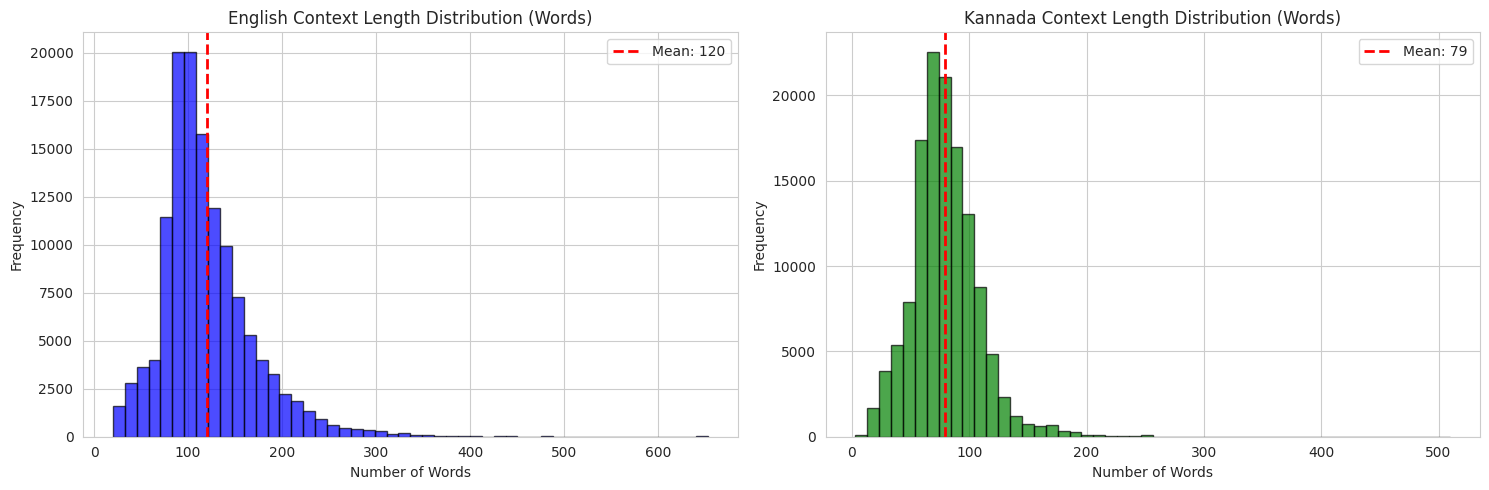

Saved: context_length_distribution.png


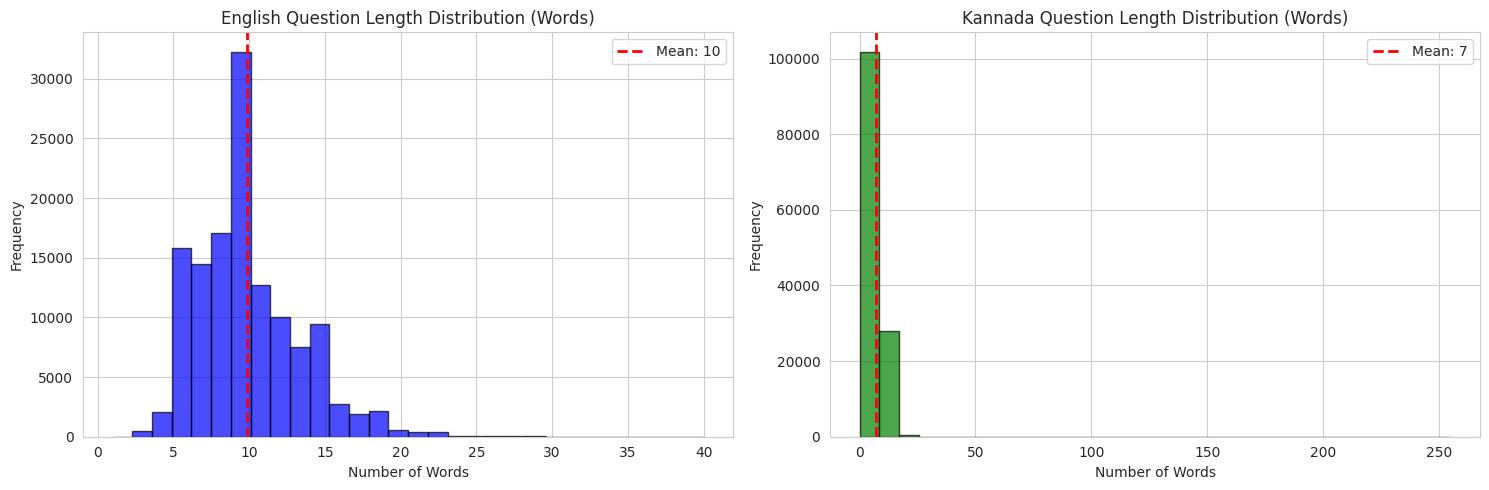

Saved: question_length_distribution.png


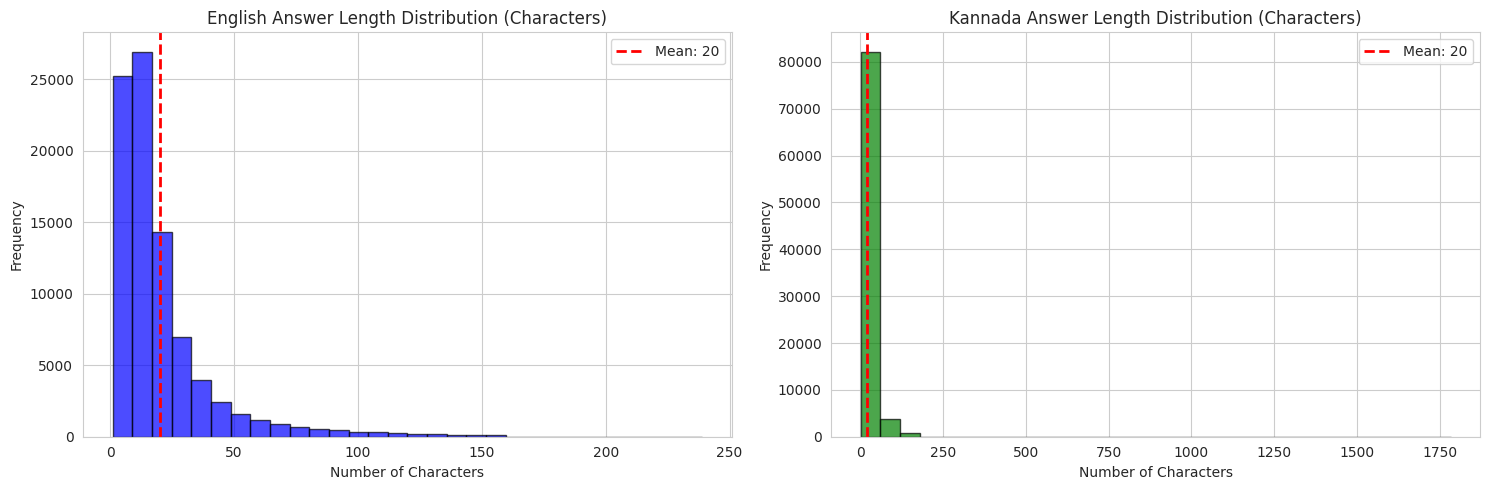

Saved: answer_length_distribution.png


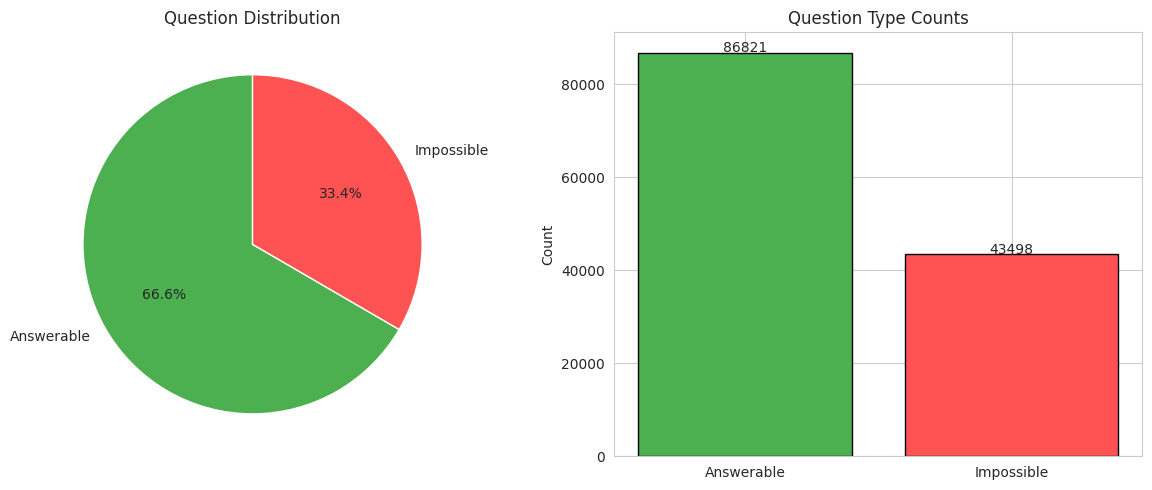

Saved: question_distribution.png


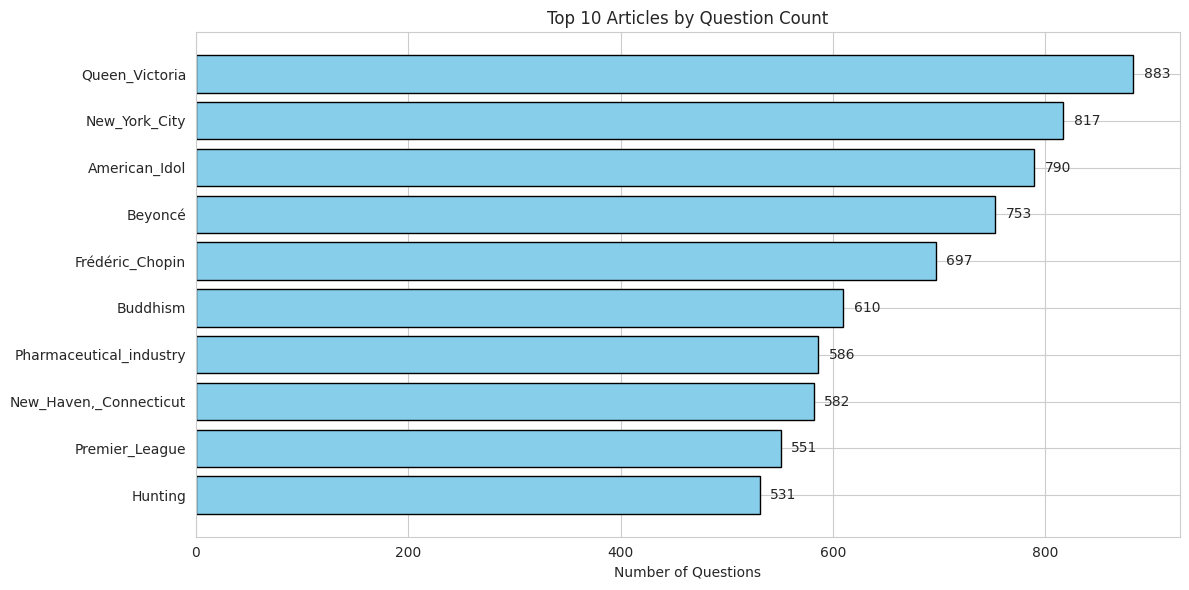

Saved: top_articles.png


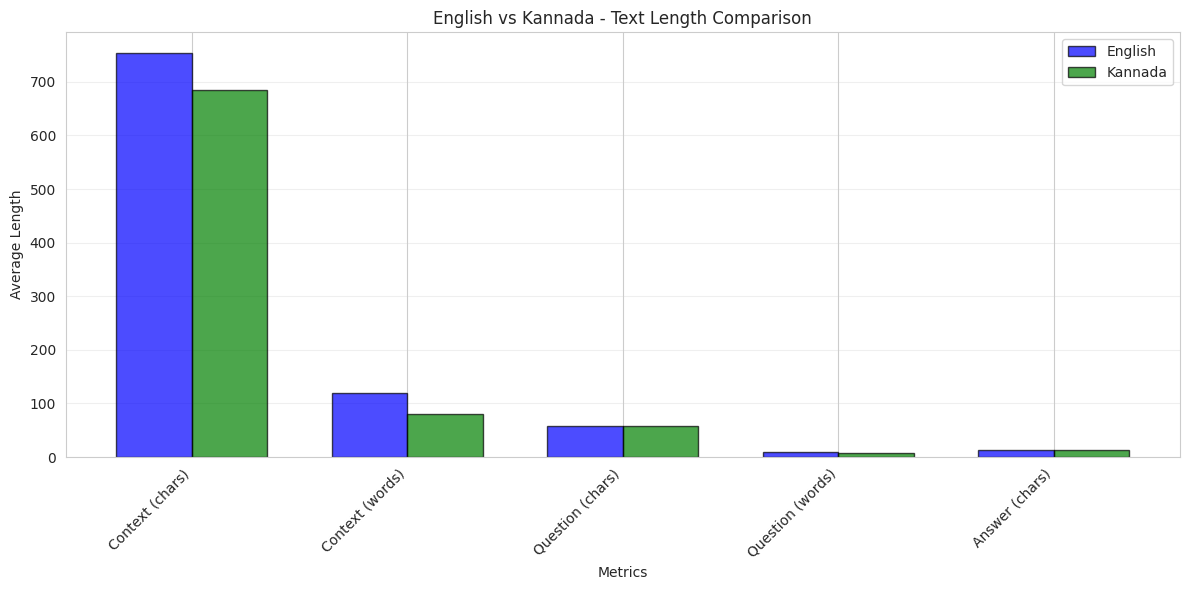

Saved: length_comparison.png

Summary Statistics:
                 Metric English Mean English Std Kannada Mean Kannada Std
 Context Length (chars)       754.57      307.62       684.26      243.31
 Context Length (words)       119.61       49.40        79.48       29.71
Question Length (chars)        58.51       73.76        57.71       29.68
Question Length (words)         9.89        3.42         6.95        3.87
  Answer Length (chars)        13.42       20.02        13.60       23.34

Saved: eda_summary_statistics.csv

EDA complete.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Loading translated dataset...")
df = pd.read_csv('squad2_train_kannada.csv')
print(f"Dataset shape: {df.shape}")

print("\nBasic Statistics:")
print(f"Total samples: {len(df)}")
print(f"Impossible questions: {df['is_impossible'].sum()} ({df['is_impossible'].sum()/len(df)*100:.2f}%)")
print(f"Answerable questions: {(~df['is_impossible']).sum()} ({(~df['is_impossible']).sum()/len(df)*100:.2f}%)")

print("\nUnique values:")
print(f"Unique articles: {df['article_title'].nunique()}")
print(f"Unique contexts: {df['context'].nunique()}")

df['context_len_eng'] = df['context'].str.len()
df['context_len_kan'] = df['context_kannada'].str.len()
df['question_len_eng'] = df['question'].str.len()
df['question_len_kan'] = df['question_kannada'].str.len()
df['answer_len_eng'] = df['answer_text'].fillna('').str.len()
df['answer_len_kan'] = df['answer_text_kannada'].fillna('').str.len()

df['context_words_eng'] = df['context'].str.split().str.len()
df['context_words_kan'] = df['context_kannada'].str.split().str.len()
df['question_words_eng'] = df['question'].str.split().str.len()
df['question_words_kan'] = df['question_kannada'].str.split().str.len()

print("\nEnglish Dataset Statistics:")
print(f"Context - Avg length: {df['context_len_eng'].mean():.2f} chars, Avg words: {df['context_words_eng'].mean():.2f}")
print(f"Question - Avg length: {df['question_len_eng'].mean():.2f} chars, Avg words: {df['question_words_eng'].mean():.2f}")
print(f"Answer - Avg length: {df['answer_len_eng'].mean():.2f} chars")

print("\nKannada Dataset Statistics:")
print(f"Context - Avg length: {df['context_len_kan'].mean():.2f} chars, Avg words: {df['context_words_kan'].mean():.2f}")
print(f"Question - Avg length: {df['question_len_kan'].mean():.2f} chars, Avg words: {df['question_words_kan'].mean():.2f}")
print(f"Answer - Avg length: {df['answer_len_kan'].mean():.2f} chars")

print("\nGenerating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['context_words_eng'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('English Context Length Distribution (Words)')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['context_words_eng'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['context_words_eng'].mean():.0f}")
axes[0].legend()

axes[1].hist(df['context_words_kan'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Kannada Context Length Distribution (Words)')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['context_words_kan'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['context_words_kan'].mean():.0f}")
axes[1].legend()

plt.tight_layout()
plt.savefig('context_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: context_length_distribution.png")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['question_words_eng'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('English Question Length Distribution (Words)')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['question_words_eng'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['question_words_eng'].mean():.0f}")
axes[0].legend()

axes[1].hist(df['question_words_kan'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Kannada Question Length Distribution (Words)')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['question_words_kan'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['question_words_kan'].mean():.0f}")
axes[1].legend()

plt.tight_layout()
plt.savefig('question_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: question_length_distribution.png")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

answer_eng = df[df['answer_len_eng'] > 0]['answer_len_eng']
answer_kan = df[df['answer_len_kan'] > 0]['answer_len_kan']

axes[0].hist(answer_eng, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('English Answer Length Distribution (Characters)')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
axes[0].axvline(answer_eng.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {answer_eng.mean():.0f}")
axes[0].legend()

axes[1].hist(answer_kan, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Kannada Answer Length Distribution (Characters)')
axes[1].set_xlabel('Number of Characters')
axes[1].set_ylabel('Frequency')
axes[1].axvline(answer_kan.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {answer_kan.mean():.0f}")
axes[1].legend()

plt.tight_layout()
plt.savefig('answer_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: answer_length_distribution.png")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

impossible_counts = df['is_impossible'].value_counts()
axes[0].pie(impossible_counts, labels=['Answerable', 'Impossible'], autopct='%1.1f%%',
            colors=['#4CAF50', '#FF5252'], startangle=90)
axes[0].set_title('Question Distribution')

axes[1].bar(['Answerable', 'Impossible'], impossible_counts.values, color=['#4CAF50', '#FF5252'], edgecolor='black')
axes[1].set_ylabel('Count')
axes[1].set_title('Question Type Counts')
for i, v in enumerate(impossible_counts.values):
    axes[1].text(i, v + 100, str(v), ha='center')

plt.tight_layout()
plt.savefig('question_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: question_distribution.png")

top_articles = df['article_title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_articles)), top_articles.values, color='skyblue', edgecolor='black')
plt.yticks(range(len(top_articles)), top_articles.index)
plt.xlabel('Number of Questions')
plt.title('Top 10 Articles by Question Count')
plt.gca().invert_yaxis()
for i, v in enumerate(top_articles.values):
    plt.text(v + 10, i, str(v), va='center')
plt.tight_layout()
plt.savefig('top_articles.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: top_articles.png")

comparison_data = {
    'Metric': ['Context (chars)', 'Context (words)', 'Question (chars)', 'Question (words)', 'Answer (chars)'],
    'English': [
        df['context_len_eng'].mean(),
        df['context_words_eng'].mean(),
        df['question_len_eng'].mean(),
        df['question_words_eng'].mean(),
        df['answer_len_eng'].mean()
    ],
    'Kannada': [
        df['context_len_kan'].mean(),
        df['context_words_kan'].mean(),
        df['question_len_kan'].mean(),
        df['question_words_kan'].mean(),
        df['answer_len_kan'].mean()
    ]
}

comparison_df = pd.DataFrame(comparison_data)
x = np.arange(len(comparison_df['Metric']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, comparison_df['English'], width, label='English', color='blue', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, comparison_df['Kannada'], width, label='Kannada', color='green', alpha=0.7, edgecolor='black')

ax.set_xlabel('Metrics')
ax.set_ylabel('Average Length')
ax.set_title('English vs Kannada - Text Length Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('length_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: length_comparison.png")

summary_stats = pd.DataFrame({
    'Metric': ['Context Length (chars)', 'Context Length (words)', 'Question Length (chars)',
               'Question Length (words)', 'Answer Length (chars)'],
    'English Mean': [
        f"{df['context_len_eng'].mean():.2f}",
        f"{df['context_words_eng'].mean():.2f}",
        f"{df['question_len_eng'].mean():.2f}",
        f"{df['question_words_eng'].mean():.2f}",
        f"{df['answer_len_eng'].mean():.2f}"
    ],
    'English Std': [
        f"{df['context_len_eng'].std():.2f}",
        f"{df['context_words_eng'].std():.2f}",
        f"{df['question_len_eng'].std():.2f}",
        f"{df['question_words_eng'].std():.2f}",
        f"{df['answer_len_eng'].std():.2f}"
    ],
    'Kannada Mean': [
        f"{df['context_len_kan'].mean():.2f}",
        f"{df['context_words_kan'].mean():.2f}",
        f"{df['question_len_kan'].mean():.2f}",
        f"{df['question_words_kan'].mean():.2f}",
        f"{df['answer_len_kan'].mean():.2f}"
    ],
    'Kannada Std': [
        f"{df['context_len_kan'].std():.2f}",
        f"{df['context_words_kan'].std():.2f}",
        f"{df['question_len_kan'].std():.2f}",
        f"{df['question_words_kan'].std():.2f}",
        f"{df['answer_len_kan'].std():.2f}"
    ]
})

print("\nSummary Statistics:")
print(summary_stats.to_string(index=False))

summary_stats.to_csv('eda_summary_statistics.csv', index=False)
print("\nSaved: eda_summary_statistics.csv")
print("\nEDA complete.")